In [1]:
import pandas as pd
import functions as fn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tickers = pd.read_csv("../data/nasdaq_comps_2016-2020.csv")

In [3]:
tickers = list(set(tickers['2019']).intersection(set(tickers['2018'])))
etf = 'QQQ'
start = '2018-01-01'
end = '2018-12-31'
cointegrationResultsIndividual = fn.runCointTestIndividual(etf, tickers, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ILMN
[*********************100%***********************]  1 of 1 completed
VRSK
[*********************100%***********************]  1 of 1 completed
MSFT
[*********************100%***********************]  1 of 1 completed
MU
[*********************100%***********************]  1 of 1 completed
JD
[*********************100%***********************]  1 of 1 completed
MXIM
[*********************100%***********************]  1 of 1 completed
LBTYK
[*********************100%***********************]  1 of 1 completed
CDNS
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FOXA: Data doesn't exist for startDate = 1514793600, endDate = 1546243200
err
[*********************100%***********************]  1 of 1 completed
AAL
[*********************100%***********************]  1 of 1 completed
LRCX
[*********************100%

In [4]:
cointegrationResultsIndividual.head()

,ticker,t-stat,pval
88,HAS,-3.476138,0.034570
63,AAPL,-3.268703,0.059170
41,TTWO,-3.186715,0.072178
81,IDXX,-3.156778,0.077458
52,SBUX,-3.125705,0.083256


In [5]:
subset = cointegrationResultsIndividual.loc[cointegrationResultsIndividual['pval'] <= 0.1]
tickers = subset['ticker'].tolist()
etf = 'QQQ'
start = '2018-01-01'
end = '2018-12-31'
synthetic_asset_rank = fn.runCointTestBasketsEG(etf, tickers, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
0 done, out of a total of  57


In [6]:
synthetic_asset_rank.head()

,ticker,t-stat,pval
21,"(HAS, TTWO, CTAS)",-4.563204,0.000962
37,"(HAS, AAPL, TTWO, CTAS)",-4.349294,0.002143
4,"(HAS, CTAS)",-3.980796,0.007647
19,"(HAS, TTWO, IDXX)",-3.974627,0.007802
2,"(HAS, IDXX)",-3.971309,0.007887


In [7]:
# Start from 01-01-2019 and end at 12-31-2019
qqq = pd.read_csv("../data/qqqMinute2019.csv")
has = pd.read_csv("../data/hasMinute2019.csv")
ttwo = pd.read_csv("../data/ttwoMinute2019.csv")
ctas = pd.read_csv("../data/ctasMinute2019.csv")

In [8]:
qqq = qqq.set_index('date_time')
qqq = qqq.rename(columns={'close': 'qqqclose'})

has = has.set_index('date_time')
has = has.rename(columns={'close': 'hasclose'})

ttwo = ttwo.set_index('date_time')
ttwo = ttwo.rename(columns={'close': 'ttwoclose'})

ctas = ctas.set_index('date_time')
ctas = ctas.rename(columns={'close': 'ctasclose'})

data = qqq[['qqqclose']].join([has[['hasclose']], ttwo[['ttwoclose']], ctas[['ctasclose']]], how='outer')
data = data.dropna()
data.tail(20)

,qqqclose,hasclose,ttwoclose,ctasclose
2019-12-31 15:30:00,212.345,105.7300,122.2000,268.2800
2019-12-31 15:31:00,212.330,105.7100,122.1600,268.3100
2019-12-31 15:32:00,212.355,105.6972,122.1200,268.3200
2019-12-31 15:33:00,212.360,105.6900,122.1800,268.4400
2019-12-31 15:34:00,212.365,105.6900,122.2200,268.4900
2019-12-31 15:35:00,212.385,105.6800,122.1800,268.4800
2019-12-31 15:36:00,212.370,105.6500,122.2000,268.4793
2019-12-31 15:37:00,212.350,105.6200,122.1700,268.4900
2019-12-31 15:38:00,212.385,105.6200,122.1298,268.5600
2019-12-31 15:39:00,212.355,105.6044,122.1050,268.5800


In [9]:
syntheticAssetLogPrice = data[['hasclose', 'ttwoclose', 'ctasclose']].apply(np.log)
qqqLogPrice = np.log(data['qqqclose'].values)

In [10]:
kf = fn.multivariateKalmanFilter(syntheticAssetLogPrice, qqqLogPrice)
state_means, state_covs = kf.filter(qqqLogPrice)
slopes=state_means[:, [0, 1, 2]]
intercept=state_means[:, 3]

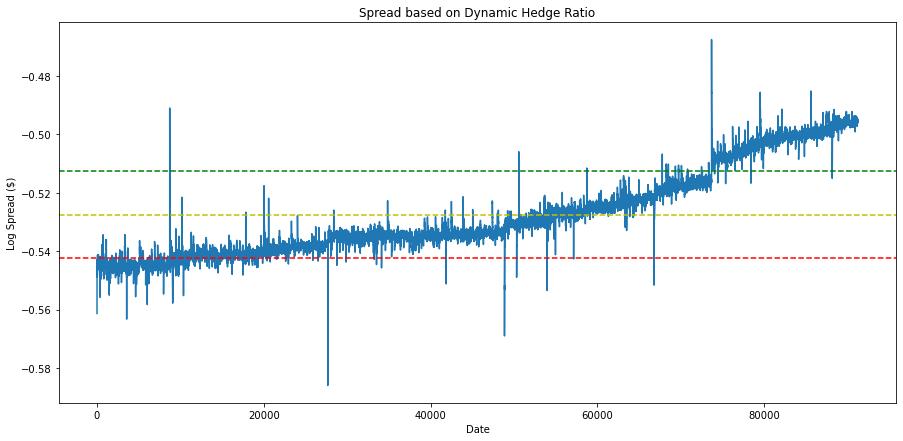

In [11]:
syntheticAssetEstimate = [np.dot(slopes[i], syntheticAssetLogPrice.values[i].T) for i in range(len(slopes))]
spread_ts = qqqLogPrice - syntheticAssetEstimate
plt.figure(figsize = (15,7))
plt.plot(spread_ts)
plt.title("Spread based on Dynamic Hedge Ratio")
plt.ylabel("Log Spread ($)")
plt.xlabel("Date")
spread_avg = spread_ts.mean()
spread_sd = spread_ts.std()
upper_threshold = spread_avg + spread_sd
lower_threshold = spread_avg - spread_sd
plt.axhline(upper_threshold, linestyle = 'dashed', color = 'g')
plt.axhline(spread_avg, linestyle = 'dashed', color = 'y')
plt.axhline(lower_threshold, linestyle = 'dashed', color = 'r')

In [12]:
# Start from 01-01-2018 and end at 12-31-2018
qqq2018 = pd.read_csv("../data/qqqMinute2018.csv")
has2018 = pd.read_csv("../data/hasMinute2018.csv")
ttwo2018 = pd.read_csv("../data/ttwoMinute2018.csv")
ctas2018 = pd.read_csv("../data/ctasMinute2018.csv")

In [13]:
qqq2018 = qqq2018.set_index('date_time')
qqq2018 = qqq2018.rename(columns={'close': 'qqqclose'})

has2018 = has2018.set_index('date_time')
has2018 = has2018.rename(columns={'close': 'hasclose'})

ttwo2018 = ttwo2018.set_index('date_time')
ttwo2018 = ttwo2018.rename(columns={'close': 'ttwoclose'})

ctas2018 = ctas2018.set_index('date_time')
ctas2018 = ctas2018.rename(columns={'close': 'ctasclose'})

data2018 = qqq2018[['qqqclose']].join([has2018[['hasclose']], ttwo2018[['ttwoclose']], ctas2018[['ctasclose']]], how='outer')
data2018 = data2018.dropna()

In [14]:
lookback_list = np.arange(10, 241, 10)
z_thresh_list = np.arange(1, 2.6, .1)
results_map = fn.tuneBBParameters(data2018, lookback_list, z_thresh_list, ['hasclose', 'ttwoclose', 'ctasclose'])

C:\Users\liuvi\Documents\fall2020\f20_stat_arb\functions.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data['logspread'] = spread_ts
C:\Users\liuvi\Documents\fall2020\f20_stat_arb\functions.py:291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data['spread'] = np.exp(spread_ts)
C:\Users\liuvi\Documents\fall2020\f20_stat_arb\functions.py:292: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


10 done, out of 384
20 done, out of 384
30 done, out of 384
40 done, out of 384
50 done, out of 384
60 done, out of 384
70 done, out of 384
80 done, out of 384
90 done, out of 384
100 done, out of 384
110 done, out of 384
120 done, out of 384
130 done, out of 384
140 done, out of 384
150 done, out of 384
160 done, out of 384
170 done, out of 384
180 done, out of 384
190 done, out of 384
200 done, out of 384
210 done, out of 384
220 done, out of 384
230 done, out of 384
240 done, out of 384
250 done, out of 384
260 done, out of 384
270 done, out of 384
280 done, out of 384
290 done, out of 384
300 done, out of 384
310 done, out of 384
320 done, out of 384
330 done, out of 384
340 done, out of 384
350 done, out of 384
360 done, out of 384
370 done, out of 384
380 done, out of 384
384 done, out of 384


In [15]:
list(results_map.items())[:10]

[((10, 1.5000000000000004),
  [40944.54670000365, 1.13567225737286, 1.95071696640599]),
 ((60, 2.200000000000001),
  [38717.37819999979, 1.1322452248262733, 2.0805256909176366]),
 ((10, 1.6000000000000005),
  [38315.495600002956, 1.1271261338657383, 1.8975701736201316]),
 ((60, 2.000000000000001),
  [35757.98779999973, 1.1219261172325412, 1.8994618347136742]),
 ((50, 2.100000000000001),
  [35809.39879999968, 1.1200074225089764, 1.9087292630443229]),
 ((10, 1.4000000000000004),
  [36973.850600002785, 1.118838906498567, 1.6567919570023628]),
 ((10, 1.7000000000000006),
  [33153.0756000012, 1.1098574838568847, 1.7190487133482095]),
 ((60, 2.100000000000001),
  [30468.45599999952, 1.1043829209715295, 1.6333364417643315]),
 ((60, 2.4000000000000012),
  [30545.441400000775, 1.1032778932543312, 2.111844638836631]),
 ((10, 1.3000000000000003),
  [33116.97990000341, 1.1018851443625093, 1.357008908170547])]

In [16]:
params = list(results_map.keys())[0]
print(params)

(10, 1.5000000000000004)


In [17]:
data.reset_index(inplace=True)
data['logspread'] = spread_ts
data['spread'] = np.exp(spread_ts)
data = data.rename(columns={'index': 'datetime'})

In [93]:
backtest_data = data[['datetime', 'qqqclose', 'hasclose', 'ttwoclose', 'ctasclose', 'spread']]
lookback = 60#params[0]
z_thresh = 2.2#params[1].round(2)

In [94]:
backtest_data = fn.createBands(backtest_data, lookback, z_thresh)

Text(0.5, 0, 'Date')

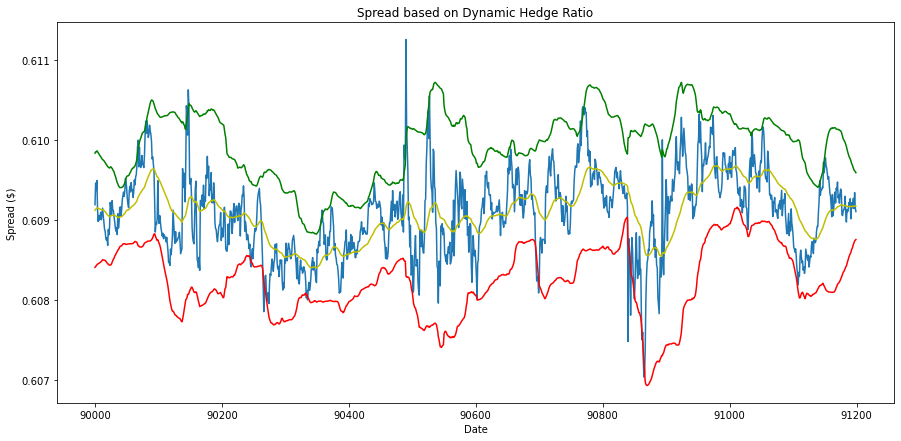

In [95]:
plt.figure(figsize = (15,7))
plt.plot(backtest_data['spread'].iloc[-1200:])
plt.plot(backtest_data['upperband'].iloc[-1200:], color='g')
plt.plot(backtest_data['ema'].iloc[-1200:], color='y')
plt.plot(backtest_data['lowerband'].iloc[-1200:], color='r')
plt.title("Spread based on Dynamic Hedge Ratio")
plt.ylabel("Spread ($)")
plt.xlabel("Date")

In [96]:
backtest_data = fn.createSignal(backtest_data)
backtest_data['position'] = backtest_data['signal'].shift(1).fillna(0)

In [97]:
backtest_data['hedgeRatioHAS'] = slopes[:, 0][lookback - 1:]
backtest_data['hedgeRatioTTWO'] = slopes[:, 1][lookback - 1:]
backtest_data['hedgeRatioCTAS'] = slopes[:, 2][lookback - 1:]

In [98]:
tradeLog = fn.constructTradeLog(backtest_data['datetime'].values, backtest_data['position'].values,
                               backtest_data['qqqclose'].values, backtest_data[['hasclose', 'ttwoclose', 'ctasclose']].values, 
                               backtest_data[['hedgeRatioHAS', 'hedgeRatioTTWO', 'hedgeRatioCTAS']].values.round(3), 
                               lot_size = 1000)
tradeLog.tail()

,start,end,holdingPeriod,positionSizeY,entryY,exitY,positionSizeX,entryX,exitX,position,profit,returns
1116,2019-01-03 13:05:00,2019-01-03 13:34:00,29,1000,151.4000,150.88,"[327.0, 372.0, 472.0]","[78.51, 101.17, 167.34]","[78.19, 100.17, 166.0529]",-1.0,-564.1512,-0.001921
1117,2019-01-03 11:53:00,2019-01-03 11:59:00,6,1000,152.1800,151.90,"[327.0, 372.0, 472.0]","[78.97, 102.535, 168.3884]","[78.76, 102.0673, 167.93]",1.0,179.0192,0.000606
1118,2019-01-03 09:42:00,2019-01-03 09:59:00,17,1000,152.6600,151.97,"[328.0, 372.0, 473.0]","[78.6301, 102.05, 169.54]","[77.9568, 101.07, 168.4]",1.0,434.6224,0.001465
1119,2019-01-02 15:02:00,2019-01-02 15:12:00,10,1000,154.9800,154.33,"[328.0, 373.0, 473.0]","[80.51899999999998, 104.11, 166.49200000000005]","[80.04, 103.35, 166.02]",1.0,13.8480,0.000046
1120,2019-01-02 11:57:00,2019-01-02 12:42:00,44,1000,154.1819,154.75,"[328.0, 372.0, 473.0]","[80.4608, 103.29, 165.9]","[80.17, 103.745, 166.0318]",-1.0,-431.8810,-0.001452


In [99]:
profitY, profitX, pos_size = fn.calculateDollarProfit(backtest_data['position'].values, backtest_data['qqqclose'].values, 
                                           backtest_data[['hasclose', 'ttwoclose', 'ctasclose']].values, 
                                           backtest_data[['hedgeRatioHAS', 'hedgeRatioTTWO', 
                                                          'hedgeRatioCTAS']].values.round(3), 
                                           lot_size = 1000)

backtest_data['totalProfit'] = fn.calculateCumulativeProfit(profitY, profitX)
backtest_data['returns'] = (profitY + profitX) / pos_size

<ipython-input-100-a91a0670c449>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns_df['cumulative_returns'] = np.cumprod(1 + backtest_data['returns'])


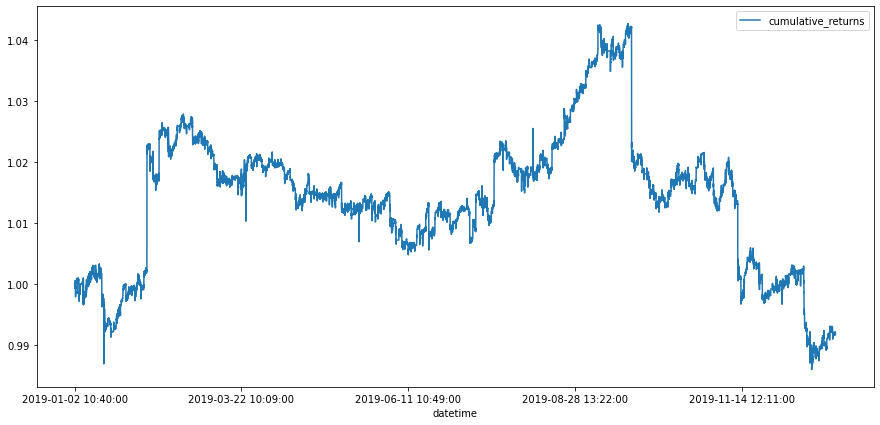

In [100]:
returns_df = backtest_data[['datetime']]
returns_df['cumulative_returns'] = np.cumprod(1 + backtest_data['returns'])
#returns_df['benchmark_returns'] = np.cumprod(1 + backtest_data['qqqclose'].pct_change())
returns_df = returns_df.set_index('datetime')
returns_df.plot(figsize=[15, 7])

In [101]:
total_profit = np.cumsum(tradeLog['profit'])
print('Trade Log cumulative profit was {:.3f}'.format(total_profit.iloc[-1]))
print('Backtest Data cumulative profit was {:.3f}'.format(backtest_data['totalProfit'].iloc[-1]))

Trade Log cumulative profit was -3777.172
Backtest Data cumulative profit was -3777.172


In [102]:
cumulative_return = np.cumprod(1 + tradeLog['returns']) - 1
print('Trade Log cumulative return was {:.3f}%'.format(cumulative_return.iloc[-1] * 100))
print('Backtest Data cumulative return was {:.3f}%'.format(100 * (returns_df['cumulative_returns'].iloc[-1] - 1)))

Trade Log cumulative return was -0.751%
Backtest Data cumulative return was -0.812%


In [103]:
backtest_data['datetime'] = pd.to_datetime(backtest_data['datetime'])
dailyReturns = fn.calculateDailyReturns(backtest_data[['datetime', 'returns']])
sharpeRatio = fn.calculateAnnualizedSharpeRatio(dailyReturns)
print('Annualized Sharpe Ratio: ', sharpeRatio)

Annualized Sharpe Ratio:  -0.1561573576980691


C:\Users\liuvi\Documents\fall2020\f20_stat_arb\functions.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minuteRets['dayperiod'] = minuteRets['datetime'].dt.to_period('D')
C:\Users\liuvi\Documents\fall2020\f20_stat_arb\functions.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minuteRets['returns'] = minuteRets['returns'] + 1


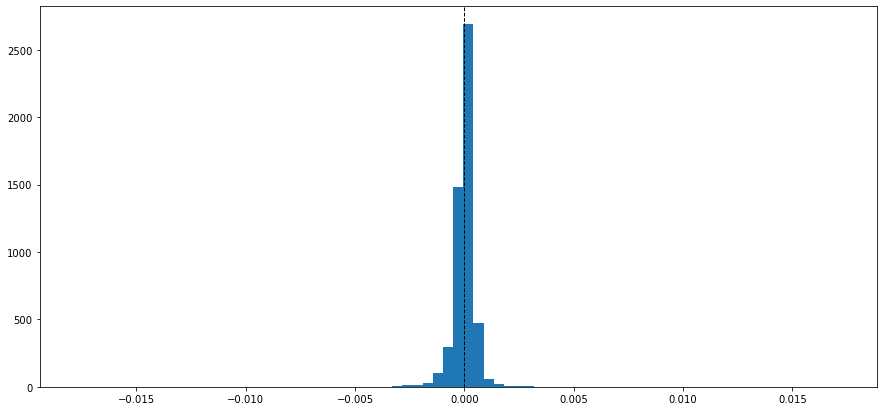

In [28]:
plt.figure(figsize=[15, 7])
plt.hist(tradeLog['returns'], bins=75)
plt.axvline(tradeLog['returns'].mean(), color='k', linestyle='dashed', linewidth=1)

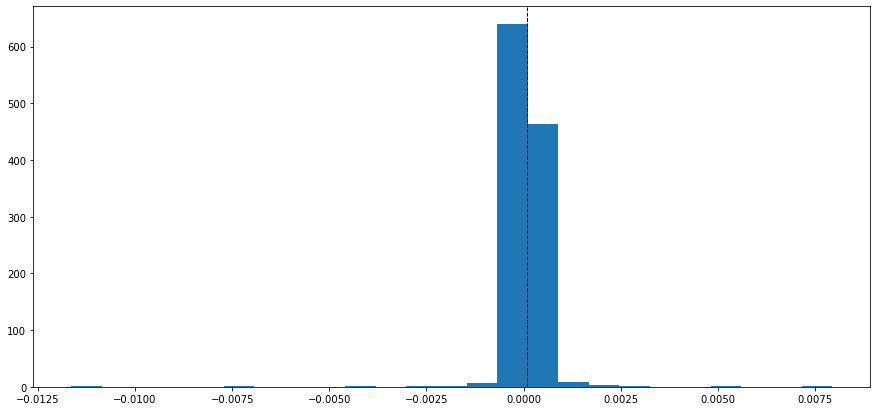

In [29]:
shortTrades = tradeLog.loc[tradeLog['holdingPeriod'] <= 2]
plt.figure(figsize=[15, 7])
plt.hist(shortTrades['returns'], bins=25)
plt.axvline(shortTrades['returns'].mean(), color='k', linestyle='dashed', linewidth=1)

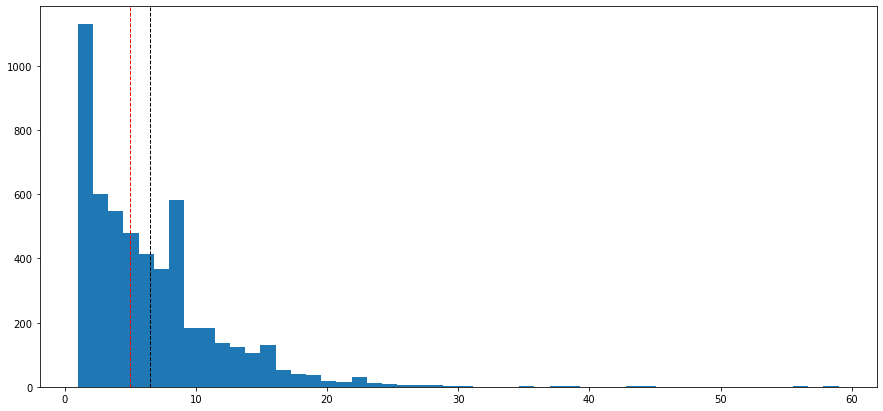

In [30]:
plt.figure(figsize=[15, 7])
plt.hist(tradeLog['holdingPeriod'], bins=50)
plt.axvline(tradeLog['holdingPeriod'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(tradeLog['holdingPeriod'].median(), color='r', linestyle='dashed', linewidth=1)